In [33]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from PIL import Image
from torchvision import transforms
from skimage.measure import compare_ssim

## Data exploration

This is a simple exploration of data structure and submission format.

First of all, run downloader.py. It will create folder 'data' and download competition data and lists. Then unzip imgs.zip to data/imgs/ folder

!python downloader.py --root ./data --main_imgs --submit_list --pairs_list

Unzip imgs to folder:

In [ ]:
!unzip imgs.zip -d imgs

In [6]:
df = pd.read_csv('data/pairs_list.csv')
df.head()

,source_imgs,target_imgs
0,60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg|b...,48f9c10f6e20153d752bbb7248016df80a16f4c3.jpg|2...
1,3e15d19b62ba5c991e8a0d9f85ddb3d8adde9a31.jpg|9...,d53757cc366571251a74d4df211b05b67a279eb2.jpg|d...
2,2cf2e394b1a4fa1d4f71a11deb5eaccfd757d668.jpg|2...,8f9faa1124481d2749ca5ec90c8762fb69a244b7.jpg|b...
3,dcf724dec8125b19bbdc5ab328f3affcdd124a3a.jpg|b...,b57e0e26f0198f3c99626a704849c88506933959.jpg|2...
4,589b3c020dbebb39d52c874dee3c4b84c4ea031a.jpg|5...,76931fc56b77730739eb46ee00da61bd4ef30b83.jpg|d...


Each line contains paths to 5 images of source id and 5 images of target id. All images are stored at 'data/imgs' folder:

In [7]:
imgs_path = 'data/imgs/'
os.listdir(imgs_path)[:10]

['ff2930c2e777fca02708f5b1cf0ee1772b5bd46c.jpg',
 'a8c23e6e57e61e79f59ec9859a5b4637b8c57996.jpg',
 '18599f1dfac060c250faf9bddbba6baf63be797f.jpg',
 '2b425644356187b7baafa6513003c4d83a831b2c.jpg',
 '64612c35899ac8858ecc99e146745e35baef1677.jpg',
 'ac95bf0d494e0dcf18d38add60fae9c4fd3203db.jpg',
 '0b48b12b2134496eded6f6707e1767b3bfafe1e5.jpg',
 '58eb2ec7315b7e2496005e58b4fbd3b2940128e9.jpg',
 '12c67ab29fcadc44f15a3c241b24676788a20d70.jpg',
 '0ea183794fd600aaa874b2ffd59ee7a7b7f201b3.jpg']

Now let's look at some pairs

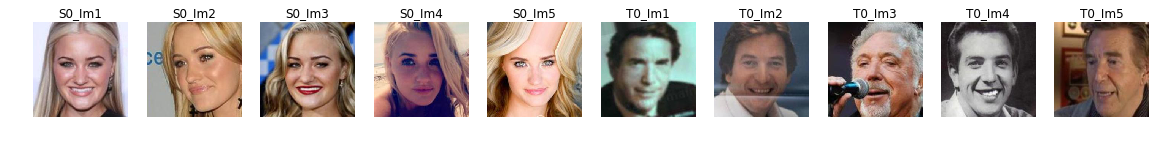

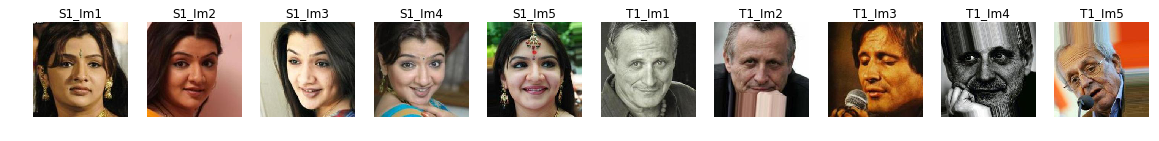

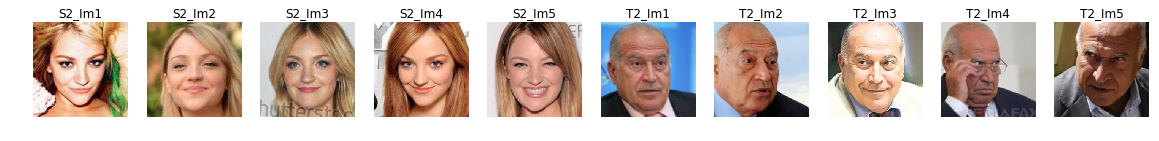

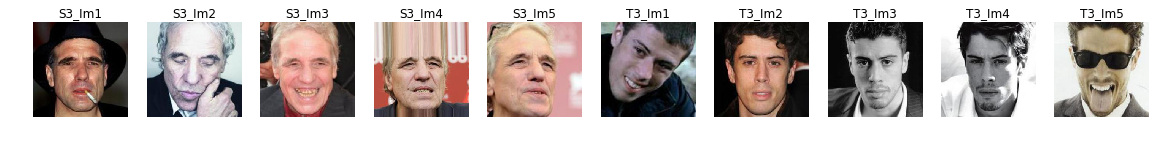

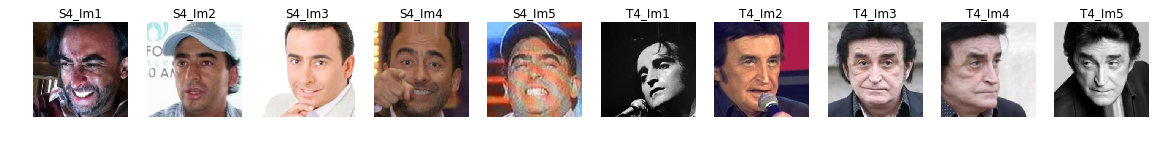

In [8]:
for idx in df.index[:5]:
    source_imgs = df.loc[idx].source_imgs
    target_imgs = df.loc[idx].target_imgs
    plt.figure(figsize=(20, 5))
    for i, img_name in enumerate(source_imgs.split('|'), 1):
        img = Image.open(os.path.join(imgs_path,img_name))
        plt.subplot(1, 10, i)
        plt.title('S{}_Im{}'.format(idx,i))
        plt.axis('off')
        plt.imshow(img)
        
    for i, img_name in enumerate(target_imgs.split('|'), 1):
        img = Image.open(os.path.join(imgs_path,img_name))
        plt.subplot(1, 10, i+5)
        plt.title('T{}_Im{}'.format(idx,i))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

## Trying black box

In order to use black box, you should place BB file near your code or add it to your Path variable. Depending on your version of python and operating system download and store corresponding version of file. Here we use MCS2018.cpython-36m-x86_64-linux-gnu.so. Once you've done this, you should be able to import MCS2018 library:


In [9]:
#import MCS2018
import data.MCS2018_CPU as MCS2018

First of all, create an instance of black box. Note, that if you have GPU available, you can specify GPU card number. If you're using CPU only, write -1

In [10]:
gpu_id = -1
net = MCS2018.Predictor(gpu_id)

Now you can get face descriptor from a photo. But first you need to preprocess image accordingly

In [11]:
def preprocess_img(img):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    preprocessing = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.Resize(112),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=MEAN, std=STD),
                    ])
    img_arr = preprocessing(img).unsqueeze(0).numpy()
    return img_arr
img_arr = preprocess_img(img)
img_arr.shape

(1, 3, 112, 112)

In [12]:
img_descriptor = net.submit(img_arr).squeeze()
img_descriptor.shape

(512,)

Distance between descriptors of the same identity is small while distance between different persons is high:

In [13]:
source_imgs = df.loc[0].source_imgs
target_imgs = df.loc[0].target_imgs

In [14]:
%%time
source_desc=[]
target_desc=[]
for img_name in source_imgs.split('|'):
    img = Image.open(os.path.join(imgs_path,img_name))
    img_arr = preprocess_img(img)
    source_desc.append(net.submit(img_arr).squeeze())
    
for img_name in target_imgs.split('|'):
    img = Image.open(os.path.join(imgs_path,img_name))
    img_arr = preprocess_img(img)
    target_desc.append(net.submit(img_arr).squeeze())

CPU times: user 13.3 s, sys: 0 ns, total: 13.3 s
Wall time: 13.3 s


In [15]:
dist = lambda x, y: np.round(np.sqrt(((x - y) ** 2).sum(axis=0)),4)

In [16]:
print('Dist between S0_Im0 and S0_Imi:',list(map(dist,5*[source_desc[0]],source_desc)))
print('Dist between S0_Im0 and T0_Imi:',list(map(dist,5*[source_desc[0]],target_desc)))

Dist between S0_Im0 and S0_Imi: [0.0, 0.8651, 0.5897, 0.9617, 0.8777]
Dist between S0_Im0 and T0_Imi: [1.2972, 1.3565, 1.351, 1.3601, 1.4243]


Your goal is to modify source images so that the distance between modified source and target is small.

## What is 'small'? SSIM metric

SSIM metric shows the similarity between 2 images. For same images, SSIM=1. For different images -1 < SSIM < 0, SSIM -> 0. In this challenge we consider SSIM distance after Image preprocessing, but before mean/std normalization:

In [17]:
def img_to_crop(img):
    preprocessing = transforms.Compose([
                    transforms.CenterCrop(224),
                    transforms.Resize(112),
                    ])
    return preprocessing(img)


def crop_to_tensor(img):
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    preprocessing = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=MEAN, std=STD),
                    ])
    img_arr = preprocessing(img).unsqueeze(0).numpy()
    return img_arr

In [18]:
from skimage.io import imsave, imread

In [19]:
img_name=source_imgs.split('|')[0]
img = Image.open(os.path.join(imgs_path,img_name))
img_crop = img_to_crop(img)

SSIM metric is sensitive even to small changes in the image. For example, let's see what happens if we change it by using jpg compression

In [20]:
img_crop.save('tmp.png')
img_crop.save('tmp.jpg')

In [21]:
img_crop_jpg=Image.open('tmp.jpg')
img_crop_png=Image.open('tmp.png')

In [22]:
compare_ssim(np.array(img_crop_jpg), np.array(img_crop_png), multichannel=True)

0.9767639703461287

The distance is also affected:

In [23]:
des_jpg=net.submit(crop_to_tensor(img_crop_jpg)).squeeze(0)
des_png=net.submit(crop_to_tensor(img_crop_png)).squeeze(0)

dist(des_jpg,des_png)

0.2092

Since this challenge is about spoofing and not dealing with compression issues, you'll submit only png images.  

## Get the student model:  

In [28]:
import torch
from torch import nn
from torch.autograd import Variable

from student_net_learning.utils import get_model
from attacker import reverse_normalize

In [65]:
class FGSM_Attacker():
    '''
    FGSM attacker: https://arxiv.org/pdf/1412.6572.pdf
    model -- white-box model for attack
    eps -- const * Clipped Noise
    ssim_thr -- min value for ssim compare
    transform -- img to tensor transform without CenterCrop and Scale
    '''
    def __init__(self, model, eps, ssim_thr, transform, img2tensor, 
                 args, max_iter=50):
        self.model = model
        self.model.eval()
        self.eps = eps
        self.ssim_thr = ssim_thr
        self.max_iter = max_iter
        self.transform = transform
        self.cropping = transforms.Compose([
                                      transforms.CenterCrop(224),
                                      transforms.Scale(112)
                                      ])
        self.img2tensor = img2tensor
        self.args = args
        self.loss = nn.MSELoss()

    def tensor2img(self, tensor, on_cuda=False):
        tensor = reverse_normalize(tensor, REVERSE_MEAN, REVERSE_STD)
        # clipping
        tensor[tensor > 1] = 1
        tensor[tensor < 0] = 0
        tensor = tensor.squeeze(0)
        if on_cuda:
            tensor = tensor.cpu()
        return transforms.ToPILImage()(tensor)

    def attack(self, attack_pairs):
        '''
        Args:
            attack_pairs (dict) - id pair, 'source': 5 imgs,
                                           'target': 5 imgs
        '''
        target_img_names = attack_pairs['target']
        target_descriptors = np.ones((len(attack_pairs['target']), 512), 
                                     dtype=np.float32)

        for idx, img_name in enumerate(target_img_names):
            img_name = os.path.join(self.args["root"], img_name)
            img = Image.open(img_name)
            tensor = self.transform(img).unsqueeze(0)
            if self.args["cuda"]:
                tensor = tensor.cuda(async=True)

            res = self.model(Variable(tensor, requires_grad=False))\
                      .data.cpu().numpy().squeeze()
            target_descriptors[idx] = res
        target_img = img

        for img_name in attack_pairs['source']:
            print ('TEST: attack on image {0}'.format(img_name))

            #img is attacked
            if os.path.isfile(os.path.join(self.args["save_root"], img_name)):
                continue

            img = Image.open(os.path.join(self.args["root"], img_name))
            original_img = self.cropping(img)
            attacked_img = original_img
            tensor = self.transform(img)
            input_var = Variable(tensor.unsqueeze(0), requires_grad=True)
    
            print ('TEST: start iterations')
            tick = time.time()
            
            for iter_number in tqdm(range(self.max_iter)):
                adv_noise = torch.zeros((3,112,112))
                
                if self.args["cuda"]:
                    adv_noise = adv_noise.cuda(async=True)

                for target_descriptor in target_descriptors:
                    target_out = Variable(torch.from_numpy(target_descriptor)\
                                          .unsqueeze(0), requires_grad=False)

                    input_var.grad = None
                    out = self.model(input_var)
                    calc_loss = self.loss(out, target_out)
                    calc_loss.backward()
                    noise = self.eps * torch.sign(input_var.grad.data).squeeze()
                    adv_noise = adv_noise + noise

                input_var.data = input_var.data - adv_noise
                changed_img = self.tensor2img(input_var.data.cpu().squeeze())

                #SSIM checking
                ssim = compare_ssim(np.array(original_img, dtype=np.float32), 
                                    np.array(changed_img, dtype=np.float32), 
                                    multichannel=True)
                if ssim < self.ssim_thr:
                    break
                else:
                    attacked_img = changed_img
            tock = time.time()
            print ('TEST: end iterations. Time: {0:.2f}sec\n'.format(tock - tick))

            if not os.path.isdir(self.args["save_root"]):
                os.makedirs(self.args["save_root"])
            attacked_img.save(os.path.join(self.args["save_root"], img_name.replace('.jpg', '.png')))
            
            if self.args["imshow"]:
                # display images difference
                plt.figure(figsize=(20, 5))
                
                plt.subplot(1, 4, 1)
                plt.axis('off')
                plt.imshow(original_img)
                
                plt.subplot(1, 4, 2)
                plt.axis('off')
                plt.imshow(np.abs(np.array(original_img) - np.array(attacked_img)))
            
                plt.subplot(1, 4, 3)
                plt.axis('off')
                plt.imshow(attacked_img)
                
                plt.subplot(1, 4, 4)
                plt.axis('off')
                plt.imshow(np.array(target_img))
                
                plt.show()

In [22]:
transform = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.Scale(112),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD),
            ])
img2tensor = transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize(mean=MEAN, std=STD)
             ])

In [23]:
SSIM_THR = 0.95

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225] 

REVERSE_MEAN = [-0.485, -0.456, -0.406]
REVERSE_STD = [1/0.229, 1/0.224, 1/0.225]

In [24]:
img_pairs = pd.read_csv("./data/pairs_list.csv")

In [25]:
loss_model = get_model('resnet18', 'weights/resnet18_scale_fold0_best.pth.tar')

=> loaded checkpoint (epoch 25)


In [66]:
attacker = FGSM_Attacker(loss_model,
                        eps=1e-2,
                        ssim_thr=SSIM_THR,
                        transform=transform,
                        img2tensor=img2tensor,
                        args={
                            "root":"./data/imgs",
                            "save_root":"./baseline/",
                            "cuda":False,
                            "imshow":True
                        },
                        max_iter=1000)

TEST: attack on image 60f5fb295648e54bd1dc0c859c8fff620ee2eb40.jpg
TEST: start iterations


TEST: end iterations. Time: 1.06sec



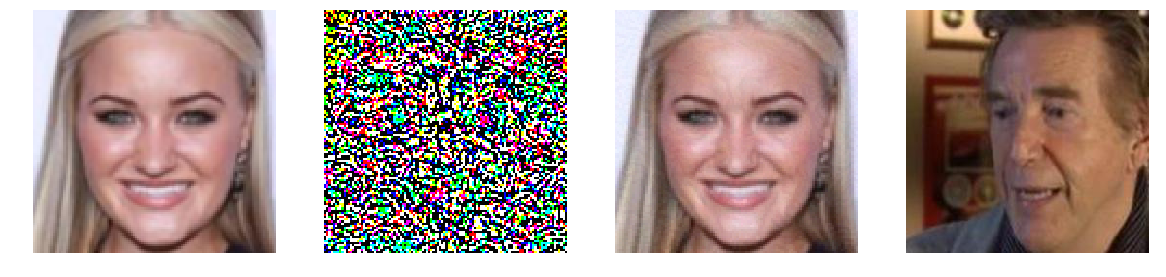

TEST: attack on image bc01280fd767ff125d851f2ccc887dce4afa834d.jpg
TEST: start iterations


TEST: end iterations. Time: 0.44sec



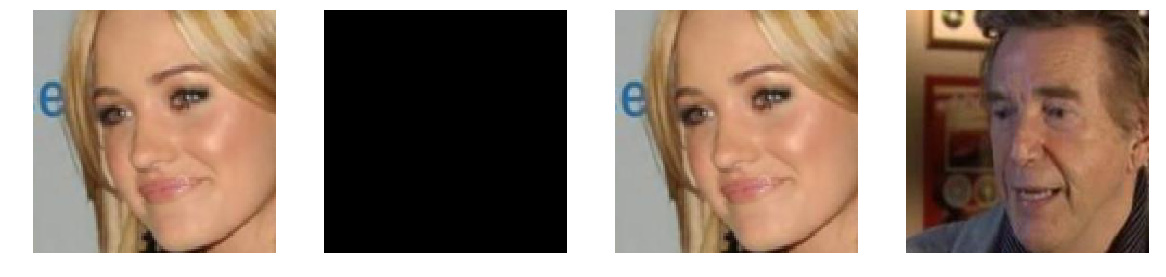

TEST: attack on image 254a446a0231b2f96699f254a880513fe9b20f39.jpg
TEST: start iterations


TEST: end iterations. Time: 2.24sec



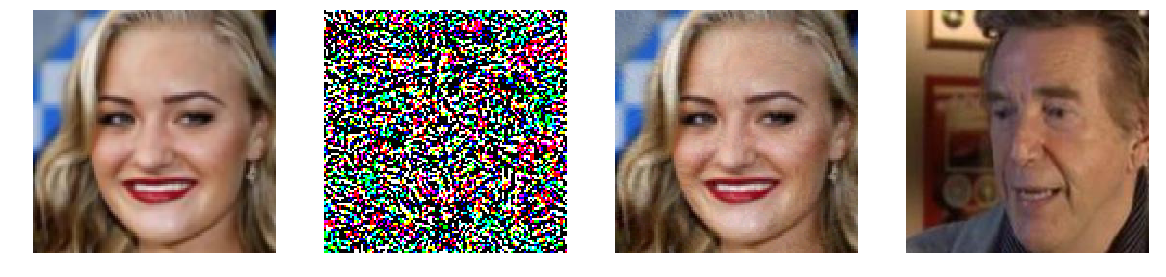

TEST: attack on image 3a3a9ad1b942aa4f4c4420b214741cf73d43373e.jpg
TEST: start iterations


TEST: end iterations. Time: 0.92sec



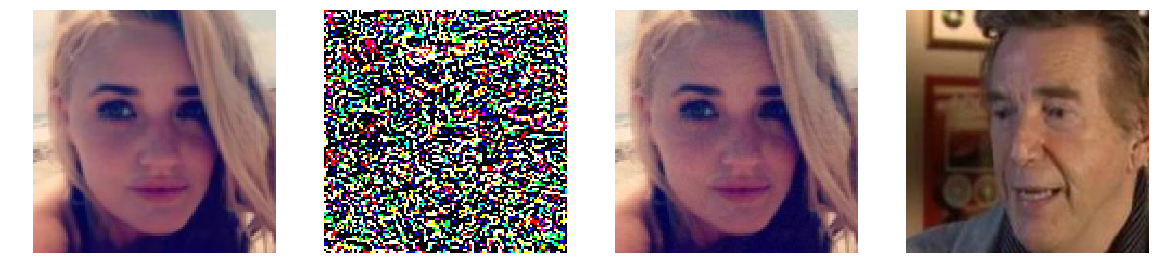

TEST: attack on image 90f023cf9e5f998ef0605687a269799164ace637.jpg
TEST: start iterations


TEST: end iterations. Time: 0.90sec



KeyboardInterrupt: 

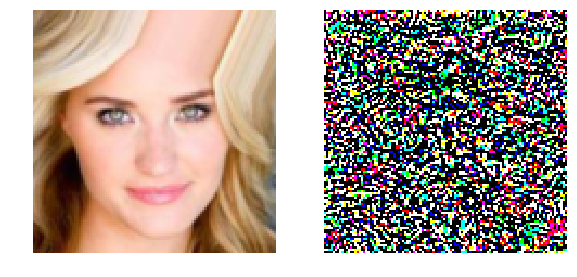

In [67]:
for idx in tqdm(img_pairs.index.values):
    pair_dict = {'source': img_pairs.loc[idx].source_imgs.split('|'),
                 'target': img_pairs.loc[idx].target_imgs.split('|')}

    attacker.attack(pair_dict)